对效果最好的模型进行可视化

In [1]:
import sys
sys.path.append('..')

In [2]:
from py_file.M_attri import Att
from py_file.Get_Data import DATA
from py_file.data_set import MyDataSet
from torch.utils.data import DataLoader,Dataset,random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import os
import math

In [3]:
# 定义训练的设备
if torch.cuda.is_available():
    device = torch.device('cuda:0') # 只有一张显卡的话，'cuda'和'cuda:0'是一样的
else:
    device = torch.device('cpu')

print(f'使用的设备为：{device}')

使用的设备为：cuda:0


In [4]:
trans = transforms.Resize(224)  # ResNet模型适合的图片大小为224x244
# 输入的张量需要带着批次维度和通道维度

# 准备模型以及数据

In [5]:
# 由于未更新的模型和语义效果更好，我们采用未更新的
# 读取模型以及语义属性
import pickle
# model = torch.load('model_saved_pseudo/all_updated.pth')
model = torch.load('model_saved_pseudo/train_all.pth')
model = model.to(device)
model.eval()

model_fea = torch.nn.Sequential(*list(model.children())[:-2])  # 由于加了sigmoid层，所以这里是[:-2]
model_fea = model_fea.to(device)
model_fea.eval()

'''
attri = Att()
attri.compute_mul_defect_att()

single_defect_att = attri.single_defect_att
two_defect_att = attri.two_defect_att
three_defect_att = attri.three_defect_att
four_defect_att = attri.four_defect_att
mul_defect_att = attri.mul_defect_att
total_defect_att = attri.total_defect_att
'''

with open('updated_semantic_all/updated_single_dict.pkl', 'rb') as file:
    single_defect_att = pickle.load(file)
with open('updated_semantic_all/updated_mul_dict.pkl', 'rb') as file:
    mul_defect_att = pickle.load(file)
with open('updated_semantic_all/updated_total_dict.pkl', 'rb') as file:
    total_defect_att = pickle.load(file)

from collections import Counter
# 加载二、三、四缺陷的字典
two_defect_att = {}
three_defect_att = {}
four_defect_att = {}
for label in mul_defect_att.keys():
    count = Counter(label)
    if count['+'] == 1:
        two_defect_att[label] = mul_defect_att[label]
    if count['+'] == 2:
        three_defect_att[label] = mul_defect_att[label]
    if count['+'] == 3:
        four_defect_att[label] = mul_defect_att[label]

In [6]:
test_data_path = '/mnt/workspace/DATA/test_WM.npz'
test_data = np.load(test_data_path)

att_dimen = len(single_defect_att['Center'])
print('att_dimen:', att_dimen)

att_dimen: 20


In [7]:
# 把标签转换为对应的属性向量
test_label = test_data['label_name']
test_att_vector = []
for l in test_data['label_name']:
    test_att_vector.append(total_defect_att[l])

test_att_vector = np.array(test_att_vector)

In [8]:
test_wm = test_data['denoise_wm']
test_wm_tensor = torch.reshape(torch.tensor(test_wm, dtype=torch.float32),(len(test_wm),1,52,52))
test_wm_tensor = trans(test_wm_tensor)
test_att_tensor = torch.tensor(test_att_vector, dtype=torch.float32)

print(test_wm_tensor.shape, test_att_tensor.shape)

torch.Size([7405, 1, 224, 224]) torch.Size([7405, 20])


In [9]:
test_label_oh = test_data['label_one_hot']
# 通过one_hot标签给数据分为单缺陷、双缺陷、三缺陷以及四缺陷

test_single_wm = []  # 先定义列表，然后转换为tensor
test_single_label = []
test_single_att = []

test_two_wm = []
test_two_label = []
test_two_att = []

test_three_wm = []
test_three_label = []
test_three_att = []

test_four_wm = []
test_four_label = []
test_four_att = []
for i in range(len(test_label_oh)):
    if test_label_oh[i].sum() <= 1:
        test_single_wm.append(np.array(test_wm_tensor[i]))
        test_single_label.append(test_label[i])
        test_single_att.append(np.array(test_att_tensor[i]))
    elif test_label_oh[i].sum() == 2:
        test_two_wm.append(np.array(test_wm_tensor[i]))
        test_two_label.append(test_label[i])
        test_two_att.append(np.array(test_att_tensor[i]))
    elif test_label_oh[i].sum() == 3:
        test_three_wm.append(np.array(test_wm_tensor[i]))
        test_three_label.append(test_label[i])
        test_three_att.append(np.array(test_att_tensor[i]))
    elif test_label_oh[i].sum() == 4:
        test_four_wm.append(np.array(test_wm_tensor[i]))
        test_four_label.append(test_label[i])
        test_four_att.append(np.array(test_att_tensor[i]))

del test_data

# 定义可视化的函数

In [10]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from py_file.M_attri import Att
from collections import OrderedDict

In [11]:
from py_file.func_Test import Test_Func
# 某些需要的函数都已经集成在了Test_Func里
func = Test_Func()

In [12]:
# 参数x是待可视化流形的高维数据;y是x中每个数据对应的字符标签;unique_label是数据的种类，是一个可以for访问的序列
# x是numpy.ndarray类型;y可以是numpy.ndarray也可以是list
def show_manifold(x, y, unique_label, last_prototype=False, prototype_num = 9, figure_size = 8, tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=5)):
    label_map_num = {}  # 将标签映射为数字,因为plt.scatter的参数c接受的标签只能用数字表示，不同的数字类别的点用不同的颜色表示
    temp = 0
    for la in unique_label:
        label_map_num[la] = temp
        temp = temp+1
    
    y_num = []
    for la in y:
        y_num.append(label_map_num[la])

    x_tsne = tsne.fit_transform(x)

    Y = list(label_map_num.keys())
    Y_num = list(label_map_num.values())

    plt.figure(figsize=(figure_size, figure_size))  # 设置图像大小

    # 绘制散点图
    if last_prototype == True:  # marker是控制散点形状的参数，默认为'o'表示圆点；'.'表示小圆点；'^'表示正三角形
        plt.scatter(x_tsne[:-prototype_num, 0], x_tsne[:-prototype_num, 1],c=y_num[:-prototype_num], cmap=plt.cm.Spectral, marker='.',edgecolor='k', s=50)
        plt.scatter(x_tsne[-prototype_num:, 0], x_tsne[-prototype_num:, 1],c=y_num[-prototype_num:], cmap=plt.cm.Spectral, marker='^', edgecolor='k', s=120)
    else:
        plt.scatter(x_tsne[:, 0], x_tsne[:, 1],c=y_num, cmap=plt.cm.Spectral, marker='.', edgecolor='k', s=50)  # c接收样本的数字标签，将不同样本点用不同的颜色表示

    # cb颜色条是根据最近的上一次的plt.scatter写入的数据来定义颜色条的
    cb = plt.colorbar() # 添加颜色条
    # 设置刻度位置
    cb.set_ticks(Y_num)  # 显示的刻度保持与Y_num一致
    # 设置刻度标签
    cb.set_ticklabels(Y)  # 这里Y中的标签是按照显示的刻度来显示标签的
    plt.title('t-SNE visualization')
    # plt.legend()
    plt.show()  # 显示图像

# 开始可视化

## 所有故障

### 语义流形

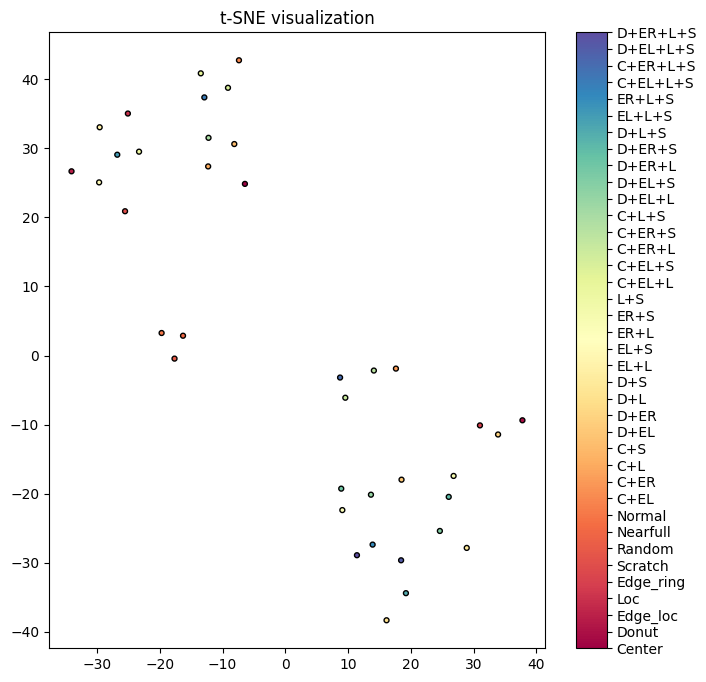

In [13]:
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=5)

X = np.array(list(total_defect_att.values()))
Y = list(total_defect_att.keys())
order_label = total_defect_att.keys()

show_manifold(X,Y,order_label,figure_size=8,tsne=tsne)

### 视觉流形

In [14]:
all_dataset = MyDataSet(test_wm_tensor, test_label)
all_loader = DataLoader(all_dataset, batch_size=32, shuffle=False)
del test_wm_tensor

In [15]:
x = []
y = list(test_label)
with torch.no_grad():
    for imgs,labels in all_loader:  
        imgs = imgs.to(device)
        outputs = model_fea(imgs)

        for out in outputs:
            x.append(out.flatten().cpu())  # 输出展开

x = np.array(x)

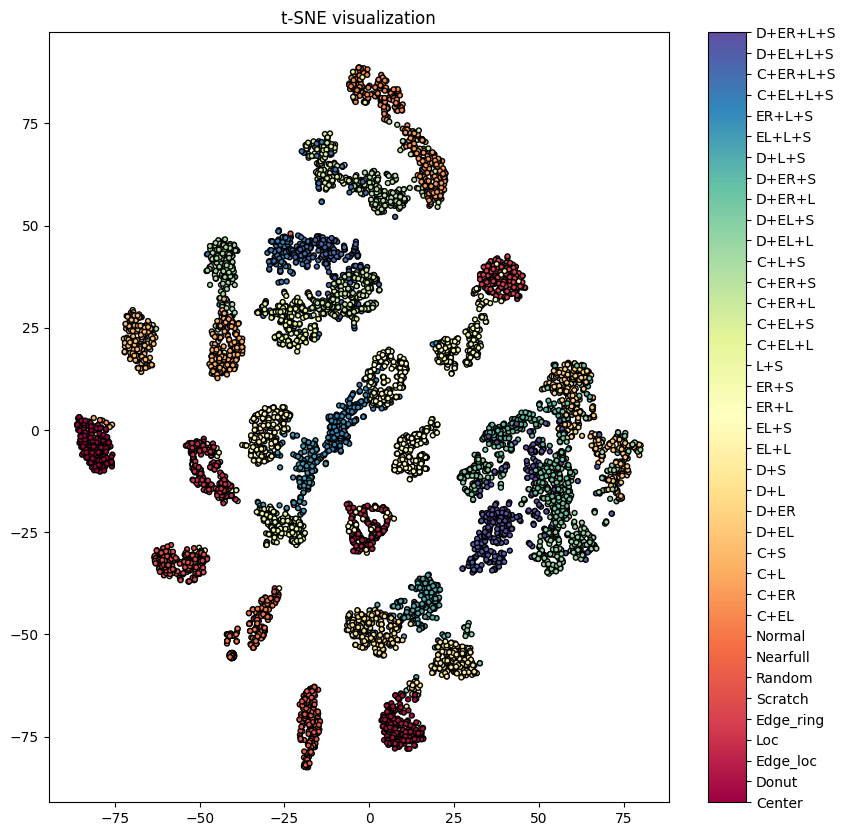

In [16]:
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=30)
show_manifold(x,y,order_label,figure_size=10,tsne=tsne)

### 视觉特征映射为属性向量后的流形

In [17]:
x = []
with torch.no_grad():
    for imgs,labels in all_loader:  
        imgs = imgs.to(device)
        outputs = model(imgs)

        for out in outputs:
            x.append(out.cpu())  # 输出展开

x = np.array(x)

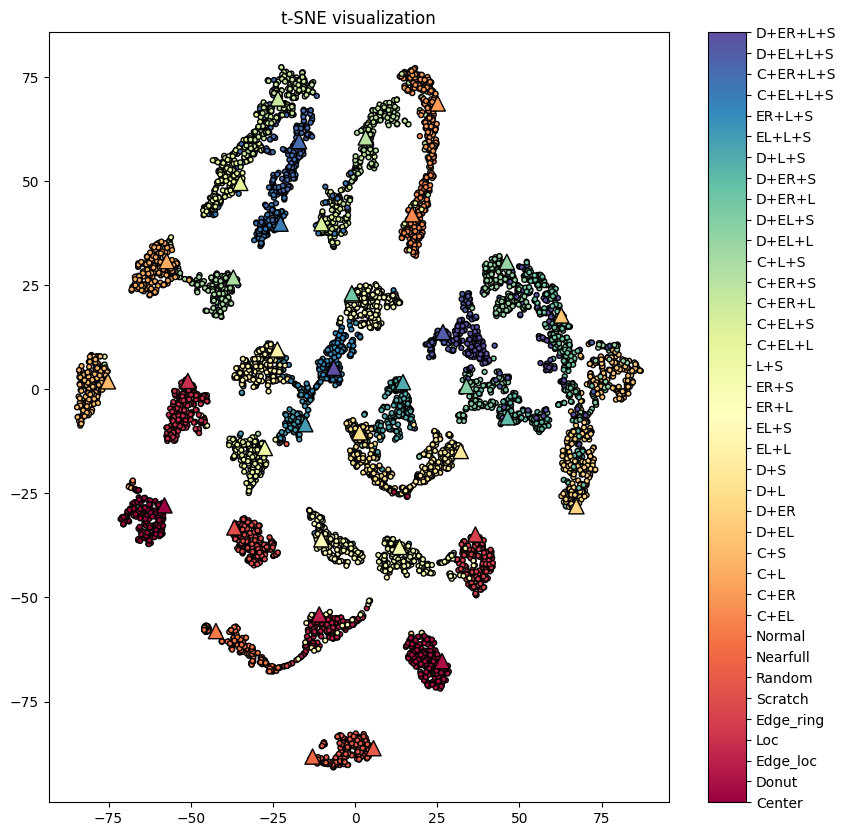

In [18]:
x = np.concatenate((x, X), axis=0)
y = y + Y
show_manifold(x,y,order_label,True, len(order_label),figure_size=10,tsne=tsne)

In [19]:
del all_dataset,all_loader

## 单故障

### 语义流形

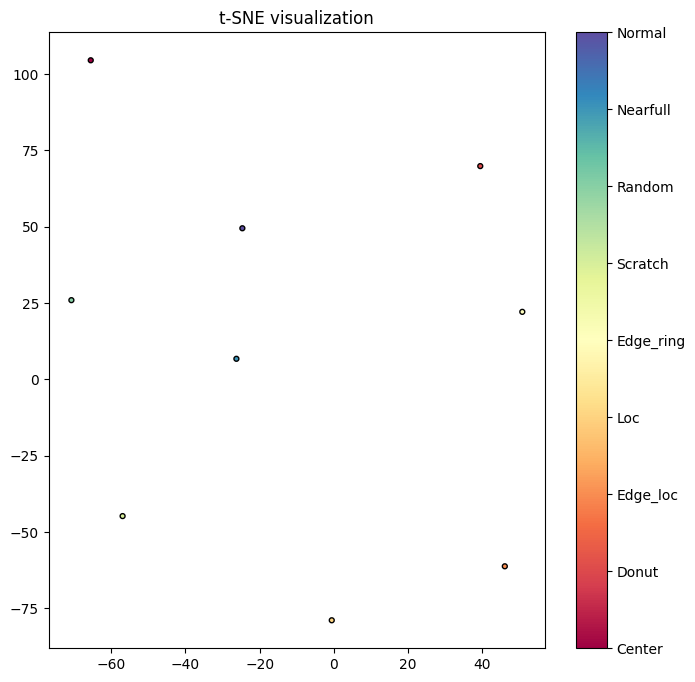

In [20]:
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=5)

X = np.array(list(single_defect_att.values()))
Y = list(single_defect_att.keys())
order_label = single_defect_att.keys()

show_manifold(X,Y,order_label,figure_size=8,tsne=tsne)

### 视觉流形

In [21]:
single_wm_tensor = torch.tensor(np.array(test_single_wm), dtype=torch.float32)
single_dataset = MyDataSet(single_wm_tensor,test_single_label)
single_loader = DataLoader(single_dataset, batch_size=32, shuffle=False)
del single_wm_tensor

In [22]:
x = []
y = test_single_label
with torch.no_grad():
    for imgs,labels in single_loader:  
        imgs = imgs.to(device)
        outputs = model_fea(imgs)

        for out in outputs:
            x.append(out.flatten().cpu())  # 输出展开,out的维度大小变为512，没有flatten的话维度大小就是(512,1,1)

x = np.array(x)

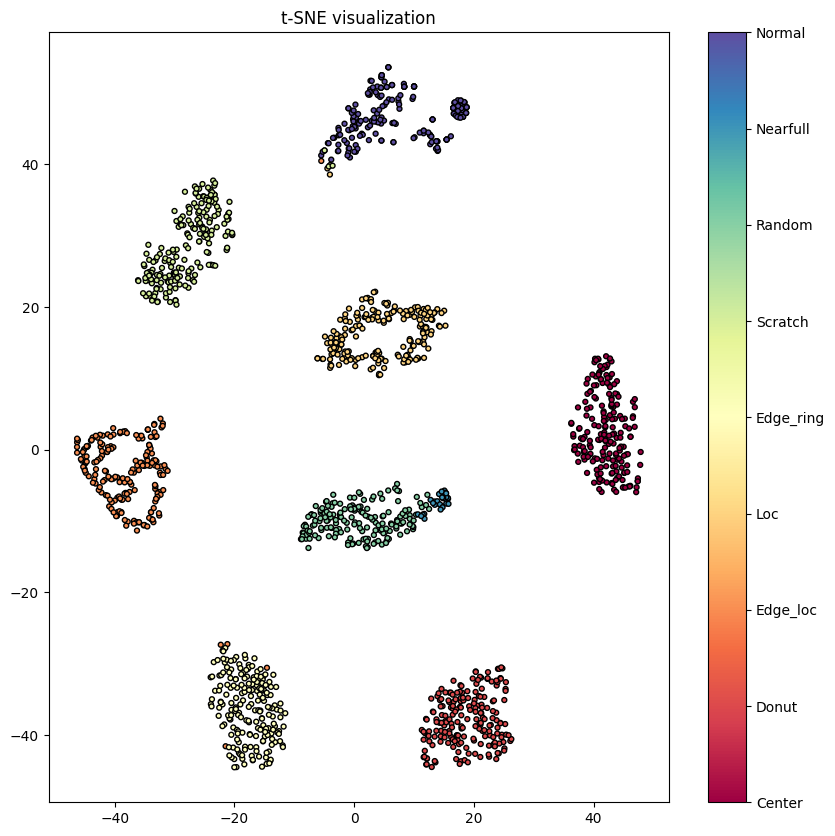

In [23]:
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=30)
show_manifold(x,y,order_label,figure_size=10,tsne=tsne)

### 视觉特征映射为属性向量后的流形

In [24]:
x = []
with torch.no_grad():
    for imgs,labels in single_loader:  
        imgs = imgs.to(device)
        outputs = model(imgs)

        for out in outputs:
            x.append(out.cpu())  # 输出展开

x = np.array(x)

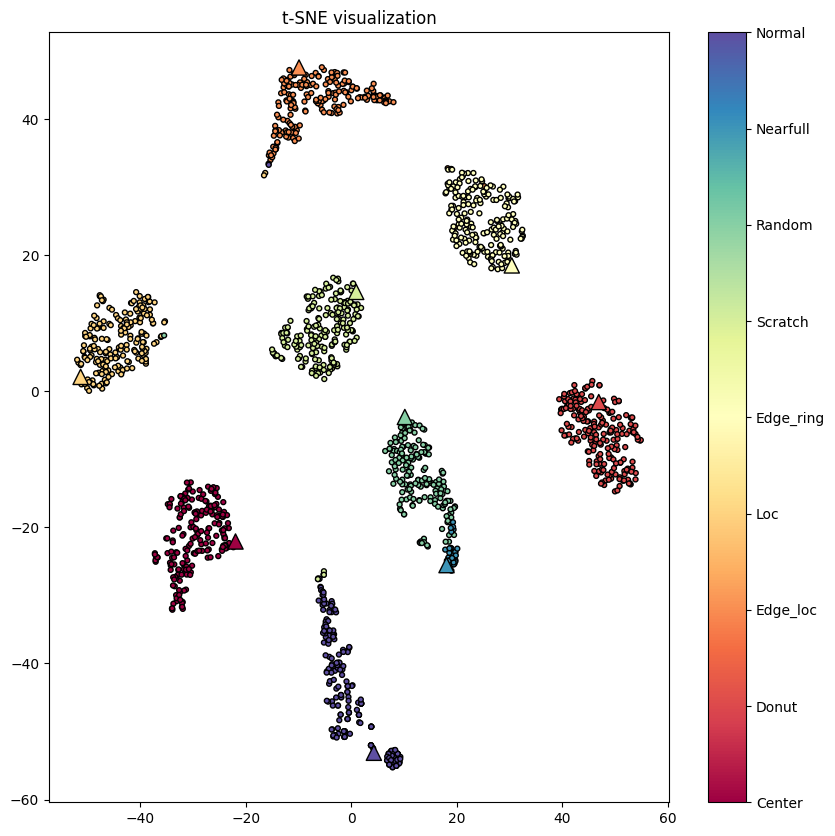

In [25]:
x = np.concatenate((x, X), axis=0)
y = y + Y
show_manifold(x,y,order_label,True, len(order_label),figure_size=10,tsne=tsne)
# 结果里如果只有一个三角形(原型)，是因为t-SNE降维后的原型距离太近，在这个图上几乎重叠了

## 二故障

### 语义流形

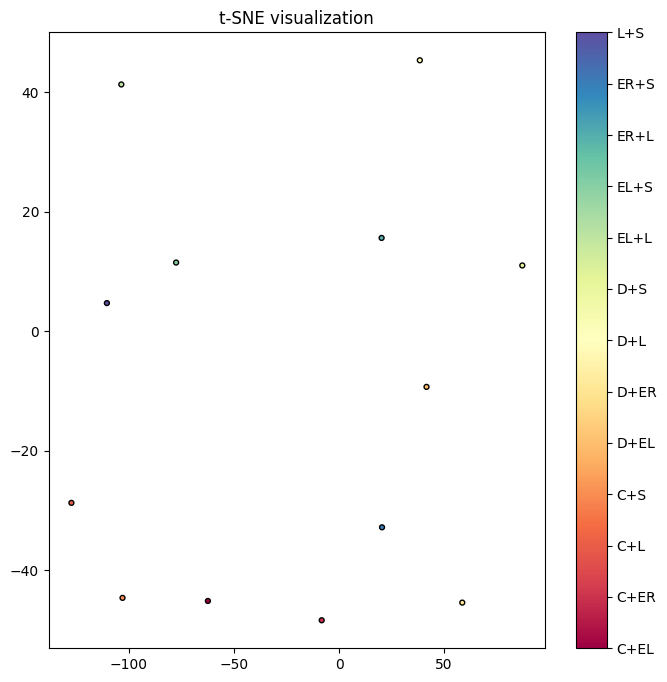

In [26]:
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=5)

X = np.array(list(two_defect_att.values()))
Y = list(two_defect_att.keys())
order_label = two_defect_att.keys()

show_manifold(X,Y,order_label,figure_size=8,tsne=tsne)

### 视觉流形

In [27]:
two_wm_tensor = torch.tensor(np.array(test_two_wm), dtype=torch.float32)
two_dataset = MyDataSet(two_wm_tensor,test_two_label)
two_loader = DataLoader(two_dataset, batch_size=32, shuffle=False)
del two_wm_tensor

In [28]:
x = []
y = test_two_label
with torch.no_grad():
    for imgs,labels in two_loader:  
        imgs = imgs.to(device)
        outputs = model_fea(imgs)

        for out in outputs:
            x.append(out.flatten().cpu())  # 输出展开

x = np.array(x)

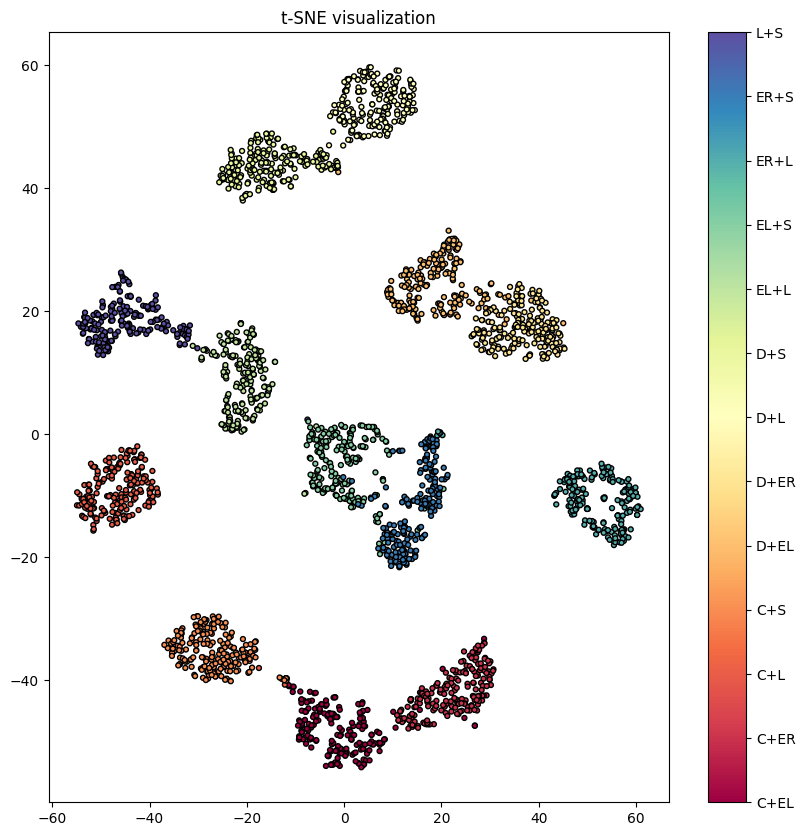

In [29]:
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=30)
show_manifold(x,y,order_label,figure_size=10,tsne=tsne)

### 视觉特征映射为属性向量后的流形

In [30]:
x = []
with torch.no_grad():
    for imgs,labels in two_loader:  
        imgs = imgs.to(device)
        outputs = model(imgs)

        for out in outputs:
            x.append(out.cpu())  # 输出展开

x = np.array(x)

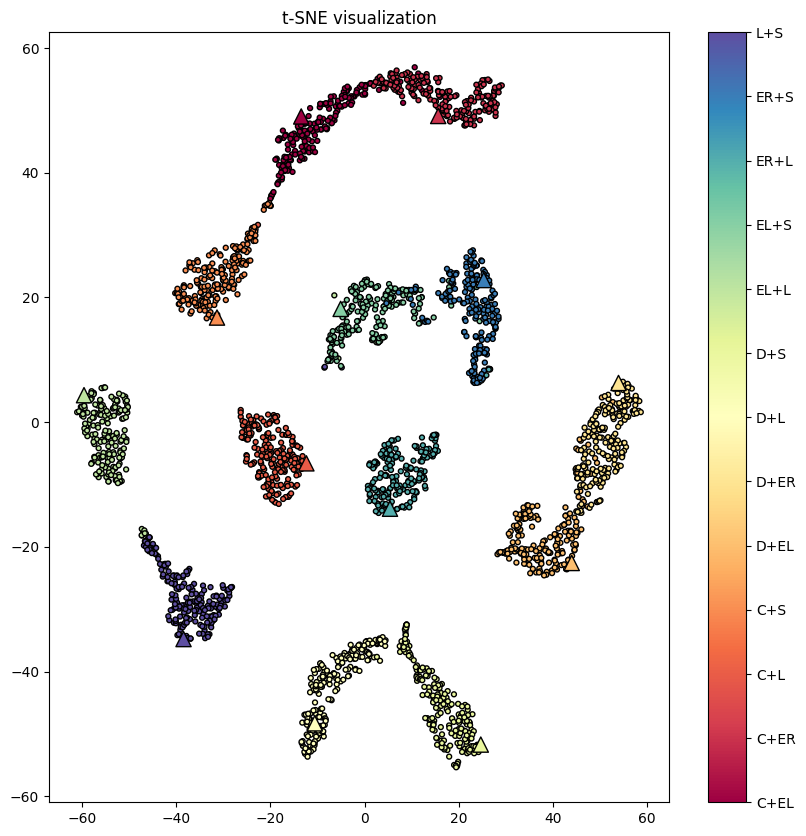

In [31]:
x = np.concatenate((x, X), axis=0)
y = y + Y
show_manifold(x,y,order_label,True, len(order_label),figure_size=10,tsne=tsne)

In [32]:
del two_dataset,two_loader

## 三故障

### 语义流形

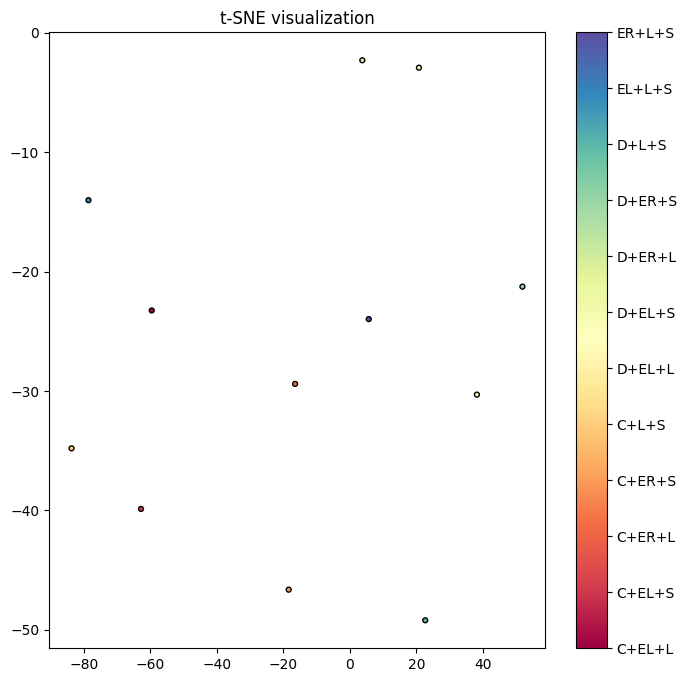

In [33]:
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=5)

X = np.array(list(three_defect_att.values()))
Y = list(three_defect_att.keys())
order_label = three_defect_att.keys()

show_manifold(X,Y,order_label,figure_size=8,tsne=tsne)

### 视觉流形

In [34]:
three_wm_tensor = torch.tensor(np.array(test_three_wm), dtype=torch.float32)
three_dataset = MyDataSet(three_wm_tensor,test_three_label)
three_loader = DataLoader(three_dataset, batch_size=32, shuffle=False)
del three_wm_tensor

In [35]:
x = []
y = test_three_label
with torch.no_grad():
    for imgs,labels in three_loader:  
        imgs = imgs.to(device)
        outputs = model_fea(imgs)

        for out in outputs:
            x.append(out.flatten().cpu())  # 输出展开

x = np.array(x)

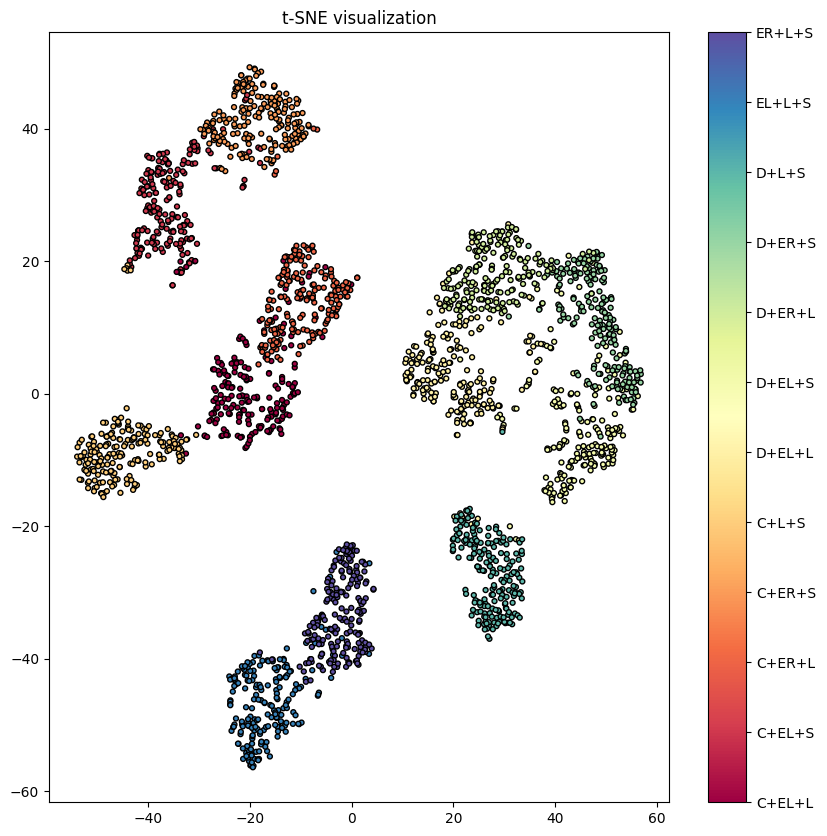

In [36]:
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=30)
show_manifold(x,y,order_label,figure_size=10,tsne=tsne)

### 视觉特征映射为属性向量后的流形

In [37]:
x = []
with torch.no_grad():
    for imgs,labels in three_loader:  
        imgs = imgs.to(device)
        outputs = model(imgs)

        for out in outputs:
            x.append(out.cpu()) 
            
x = np.array(x)

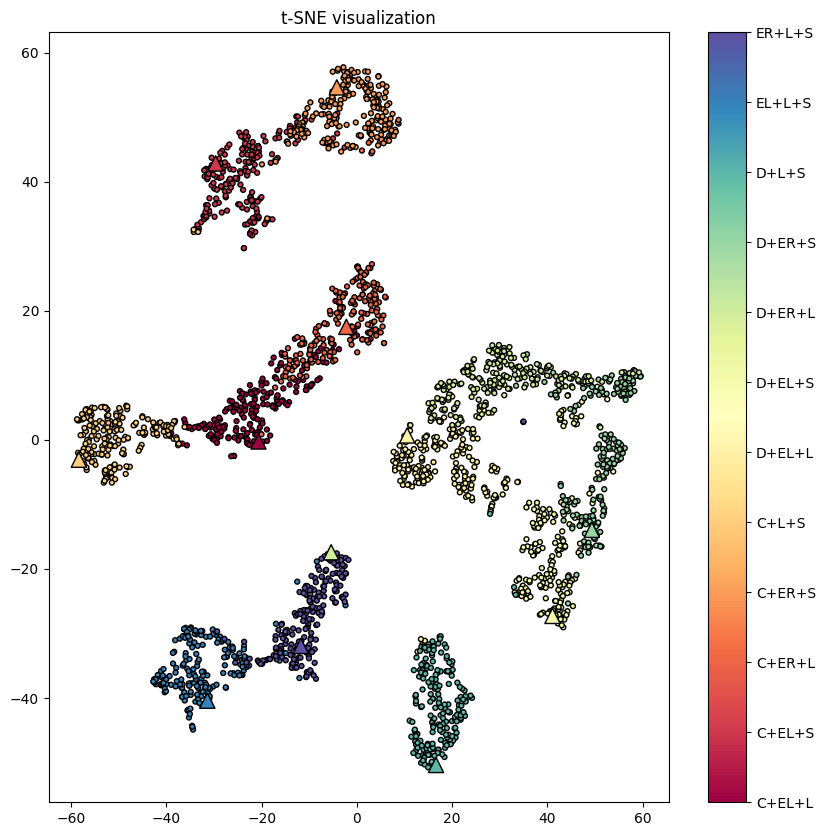

In [38]:
x = np.concatenate((x, X), axis=0)
y = y + Y
show_manifold(x,y,order_label,True, len(order_label),figure_size=10,tsne=tsne)

In [39]:
del three_dataset,three_loader

## 四故障

### 语义流形

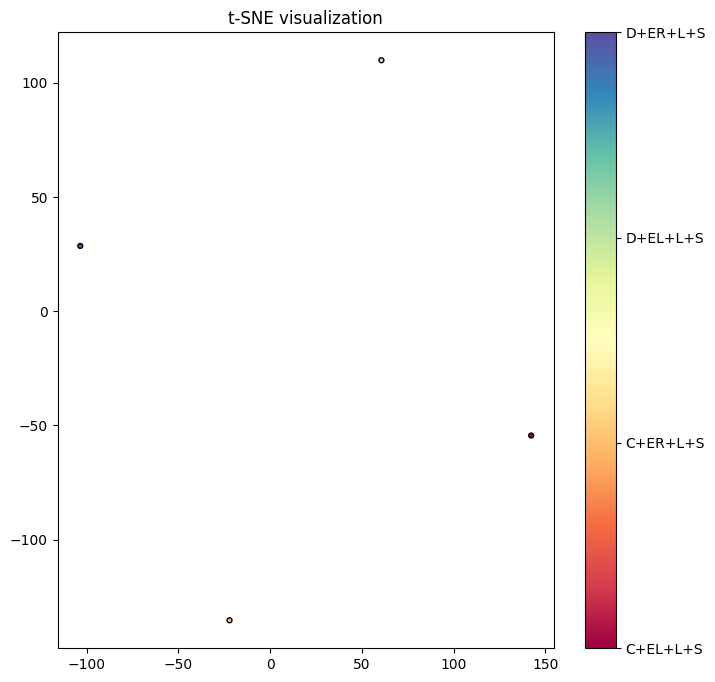

In [40]:
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=3)

X = np.array(list(four_defect_att.values()))
Y = list(four_defect_att.keys())
order_label = four_defect_att.keys()

show_manifold(X,Y,order_label,figure_size=8,tsne=tsne)

### 视觉流形

In [41]:
four_wm_tensor = torch.tensor(np.array(test_four_wm), dtype=torch.float32)
four_dataset = MyDataSet(four_wm_tensor,test_four_label)
four_loader = DataLoader(four_dataset, batch_size=32, shuffle=False)
del four_wm_tensor

In [42]:
x = []
y = test_four_label
with torch.no_grad():
    for imgs,labels in four_loader:  
        imgs = imgs.to(device)
        outputs = model_fea(imgs)

        for out in outputs:
            x.append(out.flatten().cpu())  # 输出展开

x = np.array(x)

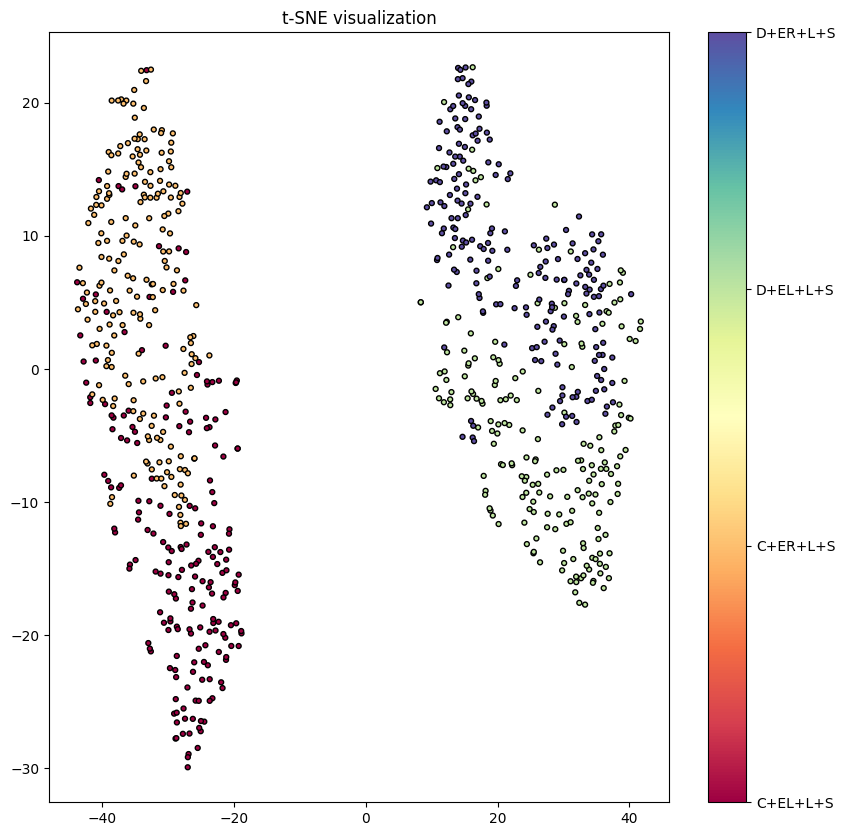

In [43]:
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=30)
show_manifold(x,y,order_label,figure_size=10,tsne=tsne)

### 视觉特征映射为属性向量后的流形

In [44]:
x = []
with torch.no_grad():
    for imgs,labels in four_loader:  
        imgs = imgs.to(device)
        outputs = model(imgs)

        for out in outputs:
            x.append(out.cpu())  # 输出展开

x = np.array(x)

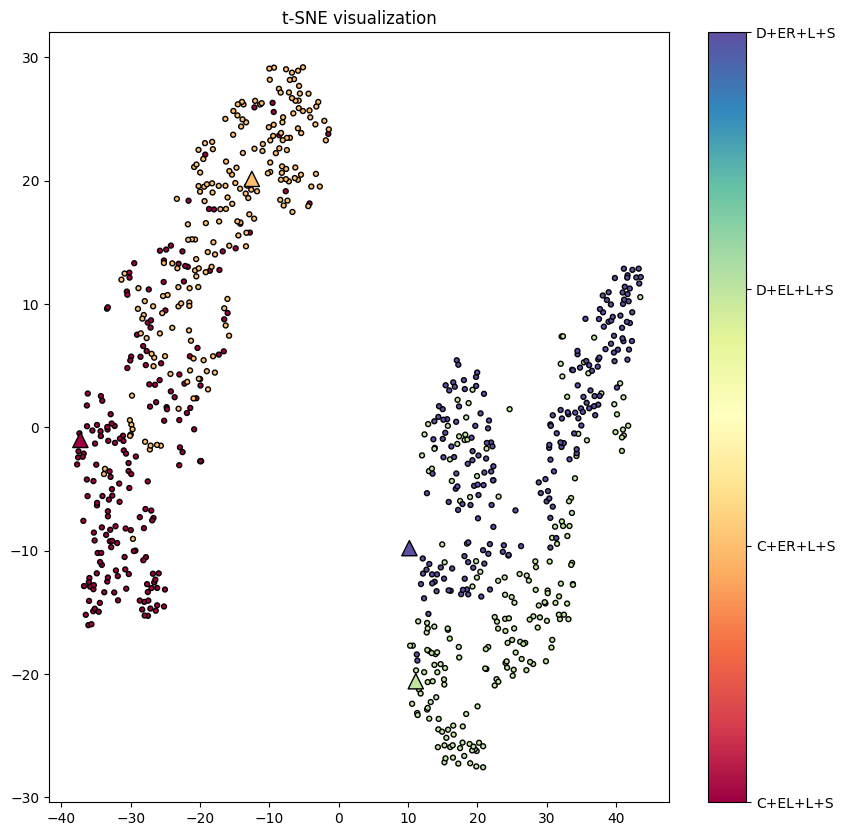

In [45]:
x = np.concatenate((x, X), axis=0)
y = y + Y
show_manifold(x,y,order_label,True, len(order_label),figure_size=10,tsne=tsne)

In [46]:
del four_dataset,four_loader